# Assignment 2 (Part b) : SVMs
# Qeustion 1 : Binary Classification 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from time import time
import math
from cvxopt import solvers, matrix

from scipy.spatial.distance import cdist

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from itertools import combinations 

from joblib import Parallel, delayed
import multiprocessing

In [2]:
def getData(train, test, val, class1=2, class2=3):
    train = train[np.logical_or(train[:,-1]==class1, train[:,-1]==class2)] 
    val = val[np.logical_or(val[:,-1]==class1, val[:,-1]==class2)] 
    test = test[np.logical_or(test[:,-1]==class1, test[:,-1]==class2)] 

    X_train = train[:,:-1]/255
    Y_train = train[:,-1]
    Y_train = np.array([-1 if i==class1 else 1 for i in Y_train]).reshape((Y_train.shape[0],1))

    X_val = val[:,:-1]/255
    Y_val = val[:,-1]
    Y_val = np.array([-1 if i==class1 else 1 for i in Y_val]).reshape((Y_val.shape[0],1))

    X_test = test[:,:-1]/255
    Y_test = test[:,-1]
    Y_test = np.array([-1 if i==class1 else 1 for i in Y_test]).reshape((Y_test.shape[0],1))
    
    return (X_train, Y_train, X_val, Y_val, X_test, Y_test)

train = pd.read_csv('./data/train.csv', header=None).to_numpy()
val = pd.read_csv('./data/val.csv', header=None).to_numpy()
test = pd.read_csv('./data/test.csv', header=None).to_numpy()

(X_train, Y_train, X_val, Y_val, X_test, Y_test) = getData(train, test, val, class1=2, class2=3)

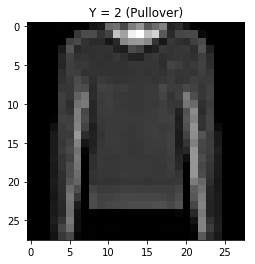

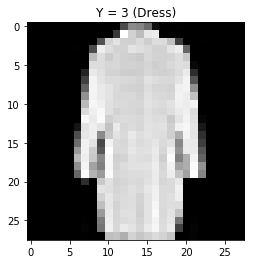

In [3]:
plt.imshow(X_train[np.where(Y_train.ravel() == -1)][0].reshape((28,28)), cmap='gray')
plt.title('Y = 2 (Pullover)')
plt.show()
plt.imshow(X_train[np.where(Y_train.ravel() == 1)][0].reshape((28,28)), cmap='gray')
plt.title('Y = 3 (Dress)')
plt.show()

## Part (a) : Implementing Linear SVM

In [4]:
class SVM:
    '''
    This class provides implementation of SVM.
    
    **************
    Parameters:
    C : Regularization parameter (Defalts 1.0)
    threshold : Threshold for alphas i.e. alpha values below this will be treated as 0 (Defalts 1e-5)
    kernel : Type of kernel you want to use ('linear' or 'rbf')
    gamma : Hyperparameter for rbf kernel
    showTime : Boolean to show time taken to fit
    **************
    '''
    __slots__=['C', 'threshold', 'kernel', 'gamma', 'showTime', 'silentCVXOPT', 'alphas', 'nSV', 'SV_indices', 'SV_y', 'SV', 'w', 'b']

    def __init__(self, C=1, threshold=1e-5, kernel='linear', gamma=0.05, showTime=True, silentCVXOPT = False):
        self.C = C
        self.threshold = threshold
        self.kernel = kernel
        self.gamma = gamma
        self.showTime = showTime
        self.silentCVXOPT = silentCVXOPT
    
    def _getRBFKernelMat(self, X, gamma = 0.05):
        return np.exp(-gamma*(cdist(X,X,'euclidean')**2))
    
    def fit(self, X_train, Y_train):
        t0 = time()
        
        if self.kernel=='linear':
            P = Y_train.dot(Y_train.T) * (X_train.dot(X_train.T))
        elif self.kernel=='rbf':
            K = self._getRBFKernelMat(X_train, self.gamma)
            P = Y_train.dot(Y_train.T) * (K)
        P=matrix(P,tc='d')

        q = -np.ones(X_train.shape[0])
        q=matrix(q,tc='d')

        G = np.vstack((-np.identity(X_train.shape[0]), np.identity(X_train.shape[0])))
        G=matrix(G,tc='d')

        h = np.hstack((np.zeros(X_train.shape[0]), np.zeros(X_train.shape[0])+self.C))
        h=matrix(h,tc='d')

        A = Y_train.T
        A = matrix(A,tc='d')
        b=matrix([0],tc='d')
        if self.silentCVXOPT:
            solvers.options['show_progress'] = False
        opt = solvers.qp(P, q, G, h, A, b)

        self.alphas = np.array(opt['x']).ravel()

        self.alphas[self.alphas<self.threshold] = 0

        self.nSV = np.where(self.alphas > 0)[0].shape[0]
        self.SV_indices = np.where(self.alphas > 0)[0]
        self.SV_y = Y_train[self.SV_indices].ravel()
        self.SV = X_train[self.SV_indices]
        
        if self.kernel == 'linear':
            self.w = (X_train[self.SV_indices]).T.dot((Y_train[self.SV_indices].ravel())*self.alphas[self.SV_indices])
            X_pos = X_train[np.where(Y_train.ravel() == 1)]
            X_neg = X_train[np.where(Y_train.ravel() == -1)]
            self.b = -(1/2)*(min(X_pos.dot(self.w)) + max(X_neg.dot(self.w)))

        elif self.kernel == 'rbf':
            X_pos_indices = np.where(Y_train.ravel() == 1)[0]
            X_neg_indices = np.where(Y_train.ravel() == -1)[0]
            alphaiXyi = self.alphas*Y_train.ravel()
            Min = math.inf
            for i in X_pos_indices:            
                Sum = 0
                for j in self.SV_indices:
                    Sum = Sum + (alphaiXyi[j] * K[i,j])
                if(Sum<Min):
                    Min=Sum
            Max = -math.inf
            for i in X_neg_indices:
                Sum = 0
                for j in self.SV_indices:
                    Sum = Sum + (alphaiXyi[j] * K[i,j])
                if(Sum>Max):
                    Max=Sum
            self.b = -(1/2)*(Max+Min)
        if self.showTime:
            print("Training completed in %.2f seconds"%((time()-t0)))
        

    def predict(self,X):
        pred = list()
        if self.kernel=='linear':
            for pt in X:
                if (self.SV).T.dot(self.SV_y*self.alphas[self.SV_indices]).dot(pt) + self.b > 0:
                    pred.append(1)
                else:
                    pred.append(-1)
        elif self.kernel=='rbf':
            wTxB = (np.exp(-0.05*cdist(self.SV, X)**2).T)@(self.alphas[self.SV_indices]*self.SV_y).reshape((-1,1)) + self.b
            wTxB[wTxB > 0] = 1
            wTxB[wTxB < 0] = -1
            pred = wTxB
        return np.array(pred, dtype='int32')
    
    def predict_score(self, X):
        score = list()
        if self.kernel=='linear':
            for pt in X:
                score.append((self.SV).T.dot(self.SV_y*self.alphas[self.SV_indices]).dot(pt) + self.b)
        elif self.kernel=='rbf':
            score = (np.exp(-0.05*cdist(self.SV, X)**2).T)@(self.alphas[self.SV_indices]*self.SV_y).reshape((-1,1)) + self.b
        return np.array(score)
        
    def get_alphas(self):
        return self.alphas
    def get_nSV(self):
        return self.nSV
    def get_SV_indices(self):
        return self.SV_indices
    def get_SV_y(self):
        return self.SV_y
    def get_SV(self):
        return self.SV
    def get_w(self):
        return self.w
    def get_b(self):
        return self.b

class metrics:
    
    def accuracy_score(y_true, y_pred):
        true = sum(y_true.ravel() == y_pred.ravel())
        return true*100/len(y_true)

In [6]:
linearSVM = SVM(C=1.0, threshold=1e-5, kernel='linear')

linearSVM.fit(X_train, Y_train)

In [6]:
print('Number of support vectors :',linearSVM.nSV)

Number of support vectors : 370


In [7]:
pred_train = linearSVM.predict(X_train)
accuracy_train = metrics.accuracy_score(Y_train, pred_train)

pred_test = linearSVM.predict(X_test)
accuracy_test = metrics.accuracy_score(Y_test, pred_test)

pred_val = linearSVM.predict(X_val)
accuracy_val = metrics.accuracy_score(Y_val, pred_val)

print('Accuracy on Train Dataset : ', accuracy_train)
print('Accuracy on Validation Dataset : ', accuracy_val)
print('Accuracy on Test Dataset : ', accuracy_test)

Accuracy on Train Dataset :  92.77777777777777
Accuracy on Validation Dataset :  89.6
Accuracy on Test Dataset :  91.3


## Part B : Applying SVM with Gaussian Kernel

In [8]:
rbfSVM = SVM(C=1.0, threshold=1e-5, kernel='rbf', gamma=0.05)

rbfSVM.fit(X_train, Y_train)

     pcost       dcost       gap    pres   dres
 0: -1.6492e+02 -6.6070e+03  3e+04  2e+00  1e-15
 1: -1.1407e+02 -3.0686e+03  5e+03  2e-01  2e-15
 2: -1.0459e+02 -7.6952e+02  9e+02  3e-02  2e-15
 3: -1.2684e+02 -3.0203e+02  2e+02  6e-03  2e-15
 4: -1.4133e+02 -2.0101e+02  6e+01  1e-03  2e-15
 5: -1.4945e+02 -1.6809e+02  2e+01  2e-04  2e-15
 6: -1.5144e+02 -1.6280e+02  1e+01  3e-05  1e-15
 7: -1.5364e+02 -1.5728e+02  4e+00  7e-06  1e-15
 8: -1.5443e+02 -1.5550e+02  1e+00  6e-16  2e-15
 9: -1.5478e+02 -1.5492e+02  1e-01  2e-15  1e-15
10: -1.5483e+02 -1.5484e+02  4e-03  3e-15  1e-15
11: -1.5483e+02 -1.5483e+02  6e-05  9e-15  2e-15
Optimal solution found.
Training completed in 122.40 seconds


In [9]:
rbfSVM.b

0.000956020409180719

In [7]:
print('Number of support vectors in RBF-SVM:',rbfSVM.nSV)

Number of support vectors in RBF-SVM: 1123


In [8]:
pred_train = rbfSVM.predict(X_train)
accuracy_train = metrics.accuracy_score(Y_train, pred_train)

pred_test = rbfSVM.predict(X_test)
accuracy_test = metrics.accuracy_score(Y_test, pred_test)

pred_val = rbfSVM.predict(X_val)
accuracy_val = metrics.accuracy_score(Y_val, pred_val)

print('Accuracy on Train Dataset :', accuracy_train)
print('Accuracy on Validation Dataset :', accuracy_val)
print('Accuracy on Test Dataset :', accuracy_test)

100%|██████████| 500/500 [00:03<00:00, 160.92it/s]

Accuracy on Train Dataset : 99.4
Accuracy on Validation Dataset : 97.2
Accuracy on Test Dataset : 96.1


In [66]:
P = Y_train.dot(Y_train.T) * (getRBFKernelMat(X_train))
P=matrix(P,tc='d')
print('Shape of P :',P.size)

q = -np.ones(X_train.shape[0])
q=matrix(q,tc='d')
print('Shape of q :',q.size)

G = np.vstack((-np.identity(X_train.shape[0]), np.identity(X_train.shape[0])))
G=matrix(G,tc='d')
print('Shape of G :',G.size)
C=1.0
h = np.hstack((np.zeros(X_train.shape[0]), np.zeros(X_train.shape[0])+C))
h=matrix(h,tc='d')
print('Shape of h :',h.size)

A = Y_train.T
A = matrix(A,tc='d')
b=matrix([0],tc='d')
print('Shape of A :',A.size)

opt = solvers.qp(P, q, G, h, A, b)

alphas = np.array(opt['x']).ravel()

# alphas[alphas<threshold] = 0

# nSV = np.where(alphas > 1e-5)[0].shape[0]
# SV_indices = np.where(alphas > 1e-5)[0]
# SV_y = Y_train[SV_indices].ravel()
# SV = X_train[SV_indices]

# w = (X_train[SV_indices]).T.dot((Y_train[SV_indices].ravel())*alphas[SV_indices])

# X_pos = X_train[np.where(Y_train.ravel() == 1)]
# X_neg = X_train[np.where(Y_train.ravel() == -1)]
# b = -(1/2)*(min(X_pos.dot(w)) + max(X_neg.dot(w)))

100%|██████████| 4500/4500 [00:35<00:00, 127.09it/s]


Shape of P : (4500, 4500)
Shape of q : (4500, 1)
Shape of G : (9000, 4500)
Shape of h : (9000, 1)
Shape of A : (1, 4500)
     pcost       dcost       gap    pres   dres
 0: -1.5598e+02 -6.9927e+03  3e+04  2e+00  1e-15
 1: -8.8657e+01 -3.4857e+03  6e+03  2e-01  2e-15
 2: -5.9446e+01 -7.3609e+02  8e+02  2e-02  2e-15
 3: -1.0523e+02 -2.6151e+02  2e+02  4e-03  2e-15
 4: -1.2171e+02 -1.8069e+02  6e+01  1e-03  1e-15
 5: -1.2850e+02 -1.5673e+02  3e+01  1e-14  1e-15
 6: -1.3314e+02 -1.4204e+02  9e+00  8e-16  1e-15
 7: -1.3446e+02 -1.3849e+02  4e+00  1e-14  1e-15
 8: -1.3538e+02 -1.3651e+02  1e+00  2e-14  1e-15
 9: -1.3573e+02 -1.3581e+02  8e-02  3e-14  1e-15
10: -1.3576e+02 -1.3576e+02  2e-03  4e-14  1e-15
11: -1.3576e+02 -1.3576e+02  6e-05  4e-15  1e-15
Optimal solution found.


## Part c : Comparing our implementation with scikit-learn's implementation

In [5]:
svm = SVC(C=1, kernel='linear')
t0 = time()
svm.fit(X_train, Y_train.ravel())
print('Linear SVM trined in %.2f sec'%(time()-t0))

# print('W : %s'%(svm.coef_))
# print('b : %s'%(svm.intercept_))
print('nSV : %s'%(svm.n_support_))
print('Total Support vectors : %s'%(svm.n_support_.sum()))

pred_train = svm.predict(X_train)
pred_val = svm.predict(X_val)
pred_test = svm.predict(X_test)

print('Accuracy on train data %.2f %c'%(accuracy_score(Y_train, pred_train)*100,'%'))
print('Accuracy on validation data %.2f %c'%(accuracy_score(Y_val, pred_val)*100,'%'))
print('Accuracy on test data %.2f %c'%(accuracy_score(Y_test, pred_test)*100,'%'))

Linear SVM trined in 0.24 sec
nSV : [33 24]
Total Support vectors : 57
Accuracy on train data 100.00 %
Accuracy on validation data 99.80 %
Accuracy on test data 100.00 %


In [4]:
svm = SVC(C=1, kernel='rbf', gamma=0.05)
t0 = time()
svm.fit(X_train, Y_train.ravel())
print('RBF SVM trined in %.2f sec'%(time()-t0))

# print('W : %s'%(svm.coef_))
# print('b : %s'%(svm.intercept_))
print('Support vectors : %s'%(svm.n_support_))
print('Total Support vectors : %s'%(svm.n_support_.sum()))

pred_train = svm.predict(X_train)
pred_val = svm.predict(X_val)
pred_test = svm.predict(X_test)

print('Accuracy on train data %.2f %c'%(accuracy_score(Y_train, pred_train)*100,'%'))
print('Accuracy on validation data %.2f %c'%(accuracy_score(Y_val, pred_val)*100,'%'))
print('Accuracy on test data %.2f %c'%(accuracy_score(Y_test, pred_test)*100,'%'))

RBF SVM trined in 3.13 sec
Support vectors : [409 417]
Total Support vectors : 826
Accuracy on train data 100.00 %
Accuracy on validation data 100.00 %
Accuracy on test data 99.80 %


$$\begin{eqnarray} \min_{w}\frac{1}{2}||w||^{2} \nonumber \\\ \textrm{s.t.}\quad y_{i}(w^{T}x_{i} + b) \ge 1 \quad \forall i \end{eqnarray}$$

$$\begin{eqnarray} \min_{\alpha}\frac{1}{2} \alpha^{T}K\alpha - 1^{T}\alpha \nonumber \\\ \textrm{s.t.}\quad \alpha_{i} \ge 0 \quad \forall i \\\ \textrm{and}\quad y^{T}\alpha = 0 \end{eqnarray}$$

$$\begin{eqnarray} \min_{x}\frac{1}{2} x^{T}Px - q^{T}x \nonumber \\\ \textrm{s.t.}\quad Gx \preceq h \\\ \textrm{and}\quad Ax = b \end{eqnarray}$$

# Question 2 : Multi-class Classification

In [5]:
class multiclassSVM:
    
    def __init__(self,C=1.0, gamma=0.05, useSklearn = False, classes = range(10), n_jobs=1):
        self.C = C
        self.gamma = 0.05
        self.useSklearn = useSklearn
        self.classes = classes
        self.comb = list(combinations(classes,2))
        self.n_jobs = n_jobs
    
    def _getData(self, X, Y, class1, class2):
        X = X[np.logical_or(Y==class1, Y==class2)] 
        Y = Y[np.logical_or(Y==class1, Y==class2)] 

        X = X/255
        Y = np.array([-1 if i==class1 else 1 for i in Y]).reshape((Y.shape[0],1))

        return (X, Y)
    
    def _getMyModel(self, c1, c2, X, Y):
        (X_train, Y_train) = self._getData(X, Y, class1=c1, class2=c2)    
        model = SVM(C=self.C, kernel='rbf', gamma=self.gamma)
        model.fit(X_train, Y_train)
        return model
    
    def _getSklearnModel(self, c1, c2, X, Y):
        (X_train, Y_train) = self._getData(X, Y, class1=c1, class2=c2)    
        model = SVC(C=self.C, kernel='rbf', gamma=self.gamma)
        model.fit(X_train, Y_train.ravel())
        return model
    
    def fit(self, X_train, Y_train):
        self.models = list()
        
        if self.useSklearn and self.n_jobs!=1:
            self.models = Parallel(n_jobs=self.n_jobs)(delayed(self._getSklearnModel)(c1, c2, X_train, Y_train) for (c1,c2) in tqdm(self.comb, desc='OneVsOne Models generation'))
        elif self.useSklearn and self.n_jobs==1:
            for (c1,c2) in tqdm(self.comb):
                self.models.append(self._getSklearnModel(c1,c2, X_train, Y_train))
        elif not self.useSklearn and self.n_jobs!=1:
            self.models = Parallel(n_jobs=self.n_jobs)(delayed(self._getMyModel)(c1, c2, X_train, Y_train) for (c1,c2) in tqdm(self.comb, desc='OneVsOne Models generation'))
        elif not self.useSklearn and self.n_jobs==1:
            for (c1,c2) in tqdm(self.comb):
                self.models.append(self._getMyModel(c1,c2, X_train, Y_train))
    
    def _predict_for_one_model(self, X, model, c0, c1):
        pred = model.predict(X)
        if not self.useSklearn:
            pred_score = model.predict_score(X)
        ######################################################################################
        else:
            pred_score = model.decision_function(X)
        pred[pred == 1] = c1
        pred[pred == -1] = c0
        return (pred, pred_score)
    
    def predict_multiclass(self, X):
        if self.n_jobs != 1:
            results = Parallel(n_jobs=self.n_jobs)(delayed(self._predict_for_one_model)(X, model, c1, c2) for (model, (c1,c2)) in tqdm(list(zip(self.models, self.comb)), desc='Generating Predictions'))
        else:
            results = [self._predict_for_one_model(X, model, c1, c2) for (model, (c1,c2)) in tqdm(list(zip(self.models, self.comb)), desc='Generating Predictions')]
        
        predScoreLst = (list(zip(*results)))
        predictions = np.array(list(predScoreLst[0]))
        predictions = predictions.reshape((predictions.shape[0], predictions.shape[1]))
        scores = np.array(list(predScoreLst[1]))
        scores = scores.reshape((scores.shape[0], scores.shape[1]))

        counts=list()
#         wo_tie = list()
        for i in (predictions.T):
            lst = np.zeros(10, dtype='int32')
            for x in i:
                lst[x]+=1
#             wo_tie.append(np.argmax(lst))
            counts.append(lst)
        np.array(counts).shape

        scores_lst = list()
        for j in (range(len(predictions.T))):
            pt_score = list()
            for i in range(10):
                pt_score.append(sum(np.abs(scores.T[j][predictions.T[j] == i])))
            scores_lst.append(pt_score)
        np.array(scores_lst).shape

        pred = list()
        for i in range(len(X)):
            scores_i = scores_lst[i]
            counts_i = counts[i]
            out = 0
            maxScore = abs(scores_i[0])
            maxCount = counts_i[0]
            for j in range(1,10):
                if counts_i[j] < maxCount:
                    continue
                elif counts_i[j] > maxCount:
                    out = j
                    maxScore = abs(scores_i[j])
                    maxCount = counts_i[j]
                else:
                    if abs(scores_i[j]) > maxScore:
                        out = j
                        maxScore = abs(scores_i[j])
                        maxCount = counts_i[j]
                    else:
                        continue
            pred.append(out)
        return pred

In [6]:
ovo = multiclassSVM(n_jobs=-1, useSklearn=True)

# with open('models.pkl', 'rb') as f:
#     models = pickle.load(f)

# ovo.models = models


In [7]:
ovo.fit(train[:,:-1]/255, train[:,-1])

OneVsOne Models generation: 100%|██████████| 45/45 [01:46<00:00,  2.37s/it]


In [8]:
len(ovo.models)

45

In [9]:
t0 = time()
pred_test = ovo.predict_multiclass(test[:,:-1]/255)
print('Predicted in %.2f minutes.'%((time()-t0)/60))

metrics.accuracy_score(test[:,-1].ravel(), np.array(pred_test))

Generating Predictions: 100%|██████████| 45/45 [03:41<00:00,  4.93s/it]


Predicted in 6.98 minutes.


15.68

In [ ]:
metrics.accuracy_score(test[:,-1].ravel(), np.array(pred_test))

In [ ]:
t0 = time()
pred_val = ovo.predict_multiclass(val[:,:-1]/255)
print('Predicted in %.2f minutes.'%((time()-t0)/60))

metrics.accuracy_score(val[:,-1].ravel(), np.array(pred_test))

In [ ]:
metrics.accuracy_score(val[:,-1].ravel(), np.array(pred_val))

In [ ]:
t0 = time()
pred_train = ovo.predict_multiclass(train[:,:-1]/255)
print('Predicted in %.2f minutes.'%((time()-t0)/60))

metrics.accuracy_score(train[:,-1].ravel(), np.array(pred_train))

In [ ]:
metrics.accuracy_score(train[:,-1].ravel(), np.array(pred_train))

In [21]:
# models = list()

# def getModel(c1,c2):
#     (X_train, Y_train, X_val, Y_val, X_test, Y_test) = getData(train, test, val, class1=c1, class2=c2)    
#     model = SVM(C=1, threshold=1e-5, kernel='rbf', gamma=0.05, )
#     model.fit(X_train, Y_train)
#     return model

# models = Parallel(n_jobs=4)(delayed(getModel)(c1, c2) for (c1,c2) in tqdm(comb, desc='OneVsOne Models generation'))

# # Sequntial code
# # for (c1,c2) in tqdm(comb):
# #     models.append(getModel(c1,c2))

# with open('models.pkl', 'rb') as f:
#     models = pickle.load(f)

# def predict_for_one_model(X, model, c0, c1):
#     pred = model.predict(X)
#     pred_score = model.predict_score(X)
#     pred[pred == 1] = c1
#     pred[pred == -1] = c0
#     return (pred, pred_score)

# def predict_multiclass(models, X, comb):

#     results = Parallel(n_jobs=-1)(delayed(predict_for_one_model)(X, model, c1, c2) for (model, (c1,c2)) in tqdm(list(zip(models, comb)), desc='Generating Predictions'))

#     predScoreLst = (list(zip(*results)))
#     predictions = np.array(list(predScoreLst[0]))
#     predictions = predictions.reshape((predictions.shape[0], predictions.shape[1]))
#     scores = np.array(list(predScoreLst[1]))
#     scores = scores.reshape((scores.shape[0], scores.shape[1]))

#     return predictions
#     counts=list()
#     wo_tie = list()
#     for i in tqdm(predictions.T):
#         lst = np.zeros(10, dtype='int32')
#         for x in i:
#             lst[x]+=1
#         wo_tie.append(np.argmax(lst))
#         counts.append(lst)
#     np.array(counts).shape
    
#     scores_lst = list()
#     for j in tqdm(range(len(predictions.T))):
#         pt_score = list()
#         for i in range(10):
#             pt_score.append(sum(np.abs(scores.T[j][predictions.T[j] == i])))
#         scores_lst.append(pt_score)
#     np.array(scores_lst).shape
    
#     pred = list()
#     for i in range(len(X)):
#         scores_i = scores_lst[i]
#         counts_i = counts[i]
#         out = 0
#         maxScore = abs(scores_i[0])
#         maxCount = counts_i[0]
#         for j in range(1,10):
#             if counts_i[j] < maxCount:
#                 continue
#             elif counts_i[j] > maxCount:
#                 out = j
#                 maxScore = abs(scores_i[j])
#                 maxCount = counts_i[j]
#             else:
#                 if abs(scores_i[j]) > maxScore:
#                     out = j
#                     maxScore = abs(scores_i[j])
#                     maxCount = counts_i[j]
#                 else:
#                     continue
#         pred.append(out)
#     return pred

In [22]:
t0 = time()
pred = predict_multiclass(models, te[:,:-1]/255, comb)
print('Predicted in %.2f minutes.'%((time()-t0)/60))

metrics.accuracy_score(te[:,-1].ravel(), np.array(pred))

NameError: name 'predict_multiclass' is not defined

In [14]:
comb = list(combinations(range(10),2))

In [63]:
t0 = time()
pred_val = predict_multiclass(models, va[:,:-1]/255, comb)
print('Predicted in %.2f minutes.'%((time()-t0)/60))


Generating Predictions: 100%|██████████| 45/45 [00:17<00:00,  2.59it/s]


Predicted in 0.85 minutes.


In [64]:
metrics.accuracy_score(va[:,-1].ravel(), np.array(pred_val))

/home/hetpatel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:133: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


TypeError: 'bool' object is not iterable

In [14]:
t0 = time()
pred_train = predict_multiclass(models, tr[:,:-1]/255, comb)
print('Predicted in %.2f minutes.'%((time()-t0)/60))

100%|██████████| 22500/22500 [00:01<00:00, 17480.59it/s]


Predicted in 9.37 minutes.


In [16]:
metrics.accuracy_score(tr[:,-1].ravel(), np.array(pred_train))

96.52

In [18]:
sklearnModels = list()

def getSklearnModel(c1, c2):
    (X_train, Y_train, X_val, Y_val, X_test, Y_test) = getData(tr, te, va, class1=c1, class2=c2)    
    model = SVC(C=1, kernel='rbf', gamma=0.05, probability=True)
    model.fit(X_train, Y_train.ravel())
    return model

results = Parallel(n_jobs=-2)(delayed(getSklearnModel)(c1, c2) for (c1,c2) in tqdm(comb, desc='OneVsOne Models generation'))
# for (c1,c2) in tqdm(combinations):
#     sklearnModels.append(getSklearnModel(c1,c2))




OneVsOne Models generation:   0%|          | 0/45 [00:00<?, ?it/s]


OneVsOne Models generation:  24%|██▍       | 11/45 [00:00<00:00, 75.91it/s]


OneVsOne Models generation:  24%|██▍       | 11/45 [00:14<00:00, 75.91it/s]


OneVsOne Models generation:  49%|████▉     | 22/45 [00:34<00:21,  1.06it/s]


OneVsOne Models generation:  73%|███████▎  | 33/45 [01:22<00:23,  1.99s/it]


OneVsOne Models generation: 100%|██████████| 45/45 [02:35<00:00,  3.45s/it]


In [51]:
pred_proba = results[0].predict_proba(va[:,:-1]/255)

In [52]:
pred_proba.shape

(2500, 2)

In [54]:
pred_proba.max(axis=1).shape

(2500,)